In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from scipy import stats
from matplotlib import pyplot as plt

%matplotlib inline

Wzmocnienie (ang. boosting) - dotyczy każdej metody zespołowej łączącej kilka klasyfikatorów słabych w klasyfikator silny. 
                              Podstawową koncepcją w wiekszości metod wzmocnienia jest sekwencyjne uczenie predyktorów w taki
                              sposób, że każdy następny próbuje korygować poprzednika. Istnieje kilka metod wzmocnienia, do tej
                              pory jednak najpopularniejsze pozostają algorytmy:
 - AdaBoost
 - wzmocnienie gradientowe (ang. gradient boosting)

In [2]:
#wczytuje dane 
darksky_data = pd.read_csv('data_pm25_plus_darksky.csv', index_col=False)
darksky_data.head()

,Unnamed: 0,date,pm25_nie,pm25_kon,pm25_wok,apparentTemperature,cloudCover,dewPoint,humidity,icon,...,windBearing,windGust,windSpeed,year,month,day,hour,day_of_week,no_of_week,winter_break
0,0,2015-01-01 00:00:00,51.5034,78.085,51.320000,32.93,1.0,29.56,0.87,NaN,...,260.0,6.93,6.93,2015,1,1,0,4,1,0
1,1,2015-01-01 01:00:00,71.8204,78.085,68.982316,33.90,1.0,31.11,0.89,NaN,...,260.0,6.93,6.93,2015,1,1,1,4,1,0
2,2,2015-01-01 02:00:00,42.6996,64.460,48.707108,27.73,1.0,31.59,0.91,cloudy,...,260.0,6.93,6.93,2015,1,1,2,4,1,0
3,3,2015-01-01 03:00:00,38.2824,36.210,37.986883,27.73,1.0,32.76,0.96,fog,...,251.0,6.93,6.93,2015,1,1,3,4,1,0
4,4,2015-01-01 04:00:00,35.4194,29.585,33.675489,26.41,1.0,32.89,0.97,fog,...,251.0,8.96,8.96,2015,1,1,4,4,1,0


In [3]:
#Preprocesing danych
darksky_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43853 entries, 0 to 43852
Data columns (total 31 columns):
Unnamed: 0             43853 non-null int64
date                   43853 non-null object
pm25_nie               43853 non-null float64
pm25_kon               43853 non-null float64
pm25_wok               43853 non-null float64
apparentTemperature    43853 non-null float64
cloudCover             43853 non-null float64
dewPoint               43853 non-null float64
humidity               43853 non-null float64
icon                   42219 non-null object
ozone                  13513 non-null float64
precipAccumulation     43853 non-null float64
precipIntensity        43853 non-null float64
precipProbability      43853 non-null float64
precipType             5442 non-null object
pressure               43853 non-null float64
summary                42219 non-null object
temperature            43853 non-null float64
time                   43853 non-null float64
uvIndex                4

In [4]:
darksky_data.isnull().sum()

Unnamed: 0                 0
date                       0
pm25_nie                   0
pm25_kon                   0
pm25_wok                   0
apparentTemperature        0
cloudCover                 0
dewPoint                   0
humidity                   0
icon                    1634
ozone                  30340
precipAccumulation         0
precipIntensity            0
precipProbability          0
precipType             38411
pressure                   0
summary                 1634
temperature                0
time                       0
uvIndex                    0
visibility                 0
windBearing                0
windGust                   0
windSpeed                  0
year                       0
month                      0
day                        0
hour                       0
day_of_week                0
no_of_week                 0
winter_break               0
dtype: int64

In [5]:
#kasowanie kolumn w których większość wierszy jest pusta + pierwszej kolumny
darksky_data.drop(['Unnamed: 0', 'icon', 'ozone', 'precipType', 'summary'],axis =1, inplace = True )

In [6]:
darksky_data.isnull().sum()

date                   0
pm25_nie               0
pm25_kon               0
pm25_wok               0
apparentTemperature    0
cloudCover             0
dewPoint               0
humidity               0
precipAccumulation     0
precipIntensity        0
precipProbability      0
pressure               0
temperature            0
time                   0
uvIndex                0
visibility             0
windBearing            0
windGust               0
windSpeed              0
year                   0
month                  0
day                    0
hour                   0
day_of_week            0
no_of_week             0
winter_break           0
dtype: int64

In [7]:
darksky_data['dewPoint'].unique()

array([29.56, 31.11, 31.59, ..., 22.36, 22.24, 18.97])

# EDA

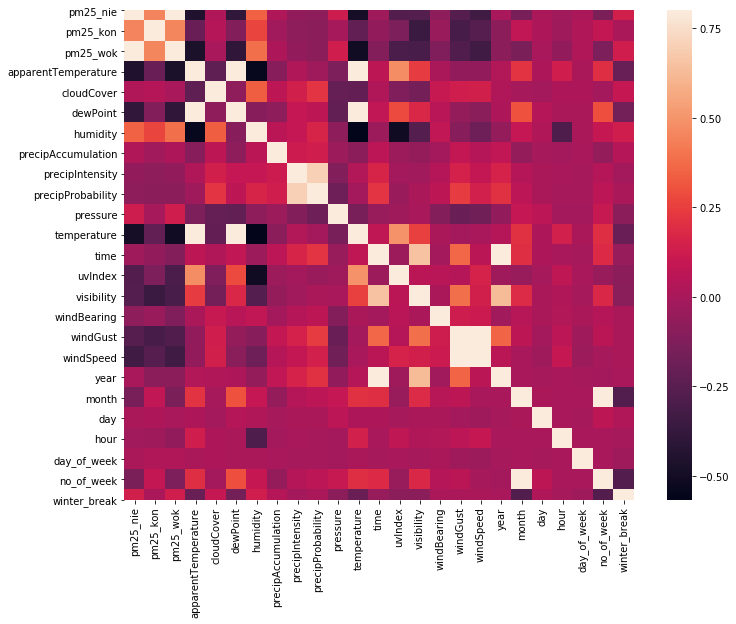

In [8]:
#Korelogram
corrmat = darksky_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

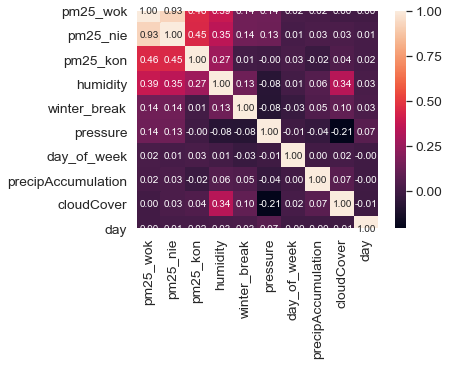

In [9]:
#9 najmocniej skorelowanych zmiennych ze zmienną objaśnianą
k = 10 #liczba zmiennych 
col = corrmat.nlargest(k, 'pm25_wok')['pm25_wok'].index
cm = np.corrcoef(darksky_data[col].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=col.values, xticklabels=col.values)
plt.show()

In [10]:
#Podział zbioru na zmienne objaśniające i zmienną objaśnianą
y = darksky_data['pm25_wok']
X = darksky_data.drop('pm25_wok', axis = 1)

In [11]:
X

,date,pm25_nie,pm25_kon,apparentTemperature,cloudCover,dewPoint,humidity,precipAccumulation,precipIntensity,precipProbability,...,windBearing,windGust,windSpeed,year,month,day,hour,day_of_week,no_of_week,winter_break
0,2015-01-01 00:00:00,51.5034,78.085,32.93,1.00,29.56,0.87,0.0,0.0,0.0,...,260.0,6.93,6.93,2015,1,1,0,4,1,0
1,2015-01-01 01:00:00,71.8204,78.085,33.90,1.00,31.11,0.89,0.0,0.0,0.0,...,260.0,6.93,6.93,2015,1,1,1,4,1,0
2,2015-01-01 02:00:00,42.6996,64.460,27.73,1.00,31.59,0.91,0.0,0.0,0.0,...,260.0,6.93,6.93,2015,1,1,2,4,1,0
3,2015-01-01 03:00:00,38.2824,36.210,27.73,1.00,32.76,0.96,0.0,0.0,0.0,...,251.0,6.93,6.93,2015,1,1,3,4,1,0
4,2015-01-01 04:00:00,35.4194,29.585,26.41,1.00,32.89,0.97,0.0,0.0,0.0,...,251.0,8.96,8.96,2015,1,1,4,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43848,2019-12-31 19:00:00,11.6000,6.900,34.07,0.82,34.28,0.75,0.0,0.0,0.0,...,307.0,28.66,14.02,2019,12,31,19,2,1,0
43849,2019-12-31 20:00:00,12.4000,6.800,33.26,0.59,34.00,0.76,0.0,0.0,0.0,...,307.0,27.30,14.39,2019,12,31,20,2,1,0
43850,2019-12-31 21:00:00,13.5000,4.400,32.30,0.29,33.20,0.76,0.0,0.0,0.0,...,305.0,26.36,14.43,2019,12,31,21,2,1,0
43851,2019-12-31 22:00:00,10.8000,4.000,31.28,0.05,32.37,0.76,0.0,0.0,0.0,...,303.0,25.92,14.14,2019,12,31,22,2,1,0


In [12]:
print(y.shape)
print(X.shape)

(43853,)
(43853, 25)


In [13]:
print(type(y))
print(type(X))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


# Zmienna objaśniania

In [14]:
#Podstawowe statystyki 
y.describe()

count    43853.000000
mean        19.677586
std         14.572871
min          1.281766
25%          9.438459
50%         15.640000
75%         25.220000
max        155.365434
Name: pm25_wok, dtype: float64

In [15]:
#Sprawdzenie braków w danych
y.isnull().sum()

0

In [16]:
#Sprawdzenie występowania wartości NaN
y.isna().sum()

0

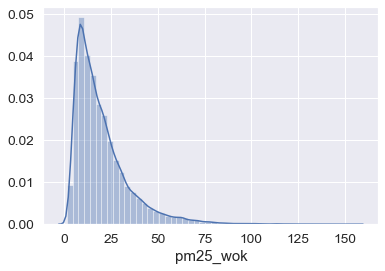

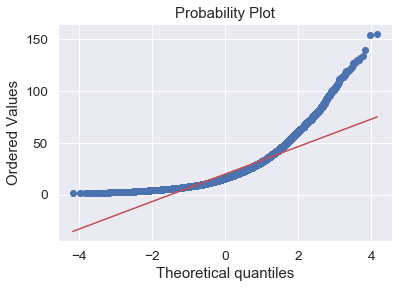

In [17]:
#Weryfikacja normalności zmiennej objaśnianej
sns.distplot(y)
fig = plt.figure()
qq = stats.probplot(darksky_data['pm25_wok'], plot=plt)

In [18]:
#Transformacja logarytmiczna
y = np.log(y)

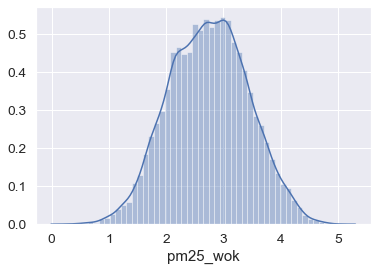

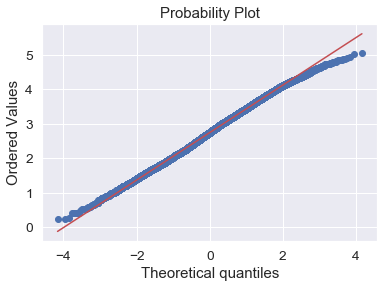

In [19]:
#Ponowna weryfikacja normalności
sns.distplot(y)
fig = plt.figure()
qq = stats.probplot(y, plot=plt)

# Zmienne objaśniające

In [20]:
X.isna().sum()

date                   0
pm25_nie               0
pm25_kon               0
apparentTemperature    0
cloudCover             0
dewPoint               0
humidity               0
precipAccumulation     0
precipIntensity        0
precipProbability      0
pressure               0
temperature            0
time                   0
uvIndex                0
visibility             0
windBearing            0
windGust               0
windSpeed              0
year                   0
month                  0
day                    0
hour                   0
day_of_week            0
no_of_week             0
winter_break           0
dtype: int64

# standaryzacja

In [21]:
X = darksky_data.drop(['date','pm25_nie','pm25_kon', 'pm25_wok'], axis = 1)

In [22]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
new_X = scaler.fit_transform(X) 

In [23]:
#podgląd co znajduje się w danych
XX = pd.DataFrame(data=new_X, columns=X.columns.values)
XX.head()

,apparentTemperature,cloudCover,dewPoint,humidity,precipAccumulation,precipIntensity,precipProbability,pressure,temperature,time,...,windBearing,windGust,windSpeed,year,month,day,hour,day_of_week,no_of_week,winter_break
0,-0.805672,1.295937,-0.893159,0.800943,-0.067898,-0.155843,-0.232741,1.261237,-1.095354,-1.732598,...,0.706354,-0.478806,-0.150388,-1.414601,-1.600262,-1.672074,-1.661085,0.000376,-1.699088,-0.189294
1,-0.754343,1.295937,-0.772911,0.911695,-0.067898,-0.155843,-0.232741,1.261237,-1.035694,-1.732519,...,0.706354,-0.478806,-0.150388,-1.414601,-1.600262,-1.672074,-1.516629,0.000376,-1.699088,-0.189294
2,-1.080839,1.295937,-0.735673,1.022447,-0.067898,-0.155843,-0.232741,1.261237,-1.041229,-1.732440,...,0.706354,-0.478806,-0.150388,-1.414601,-1.600262,-1.672074,-1.372173,0.000376,-1.699088,-0.189294
3,-1.080839,1.295937,-0.644905,1.299326,-0.067898,-0.155843,-0.232741,1.261237,-1.041229,-1.732361,...,0.610472,-0.478806,-0.150388,-1.414601,-1.600262,-1.672074,-1.227717,0.000376,-1.699088,-0.189294
4,-1.150689,1.295937,-0.634820,1.354702,-0.067898,-0.155843,-0.232741,1.261237,-1.046150,-1.732282,...,0.610472,-0.193183,0.363383,-1.414601,-1.600262,-1.672074,-1.083262,0.000376,-1.699088,-0.189294


# Modelowanie

podstawa

In [24]:
#podział na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.3, random_state = 123)

In [25]:
#Rozmiar zbiorów
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30697, 22)
(13156, 22)
(30697,)
(13156,)


In [50]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
#!!------------
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
##!!-----------
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from math import sqrt, log2
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score

Ważne hiperparametry Gradient Boosting:
- learning_rate - określa udział każdego drzewa w zepole. Niewielka wartość tego wskaźnik np. 0,1 wymaga większej liczby drzew. 
                  Jednak zbyt duża ilość drzew może powodować przeuczenie.
- n_estimators - określa liczbę drzew                  
- max_depth - (domyślnie - 3) maksymalna głębokość poszczególnych estymatorów regresji. Maksymalna głębokość ogranicza liczbę węzłów w drzewie. 
- min_samples_leaf - (domyślnie - 1) - Minimalna liczba próbek wymagana w węźle liścia. Punkt podziału na dowolnej głębokości będzie brany pod uwagę tylko wtedy, gdy pozostawi co najmniej próbki treningowe min_samples_leaf w każdej lewej i prawej gałęzi. Może to mieć efekt wygładzenia modelu, szczególnie w regresji. 
- max_features - Liczba funkcji, które należy wziąć pod uwagę, szukając najlepszego podziału:
               Jeśli „auto”, to max_features = n_features.
               Jeśli „sqrt”, to max_features = sqrt (n_features).
               Jeśli „log2”, to max_features = log2 (n_features).
               Jeśli Brak, to max_features = n_features.
- min_samples_split - Minimalna liczba próbek wymagana do podzielenia węzła wewnętrznego:
                    Jeśli int, to uważaj min_samples_split za minimalną liczbę.
                    Jeśli zmiennoprzecinkowe, to min_samples_split jest ułamkiem, a pułap (min_samples_split * n_samples) to minimalna liczba próbek dla każdego podziału.
- loss - Konkretny obiekt funkcji straty.
- random_state - Jeśli int, parametr_state_state jest ziarnem używanym przez generator liczb losowych; Jeśli instancja RandomState, random_state jest generatorem liczb losowych; Jeśli Brak, generator liczb losowych jest instancją RandomState używaną przez np.random.
- n_iter_no_change - służy do decydowania, czy wcześniejsze zatrzymanie zostanie zastosowane do zakończenia treningu, gdy wynik walidacji nie poprawi się. Domyślnie jest ustawiony na Brak, aby wyłączyć wczesne zatrzymywanie. Jeśli zostanie ustawiony na liczbę, odrzuci rozmiar danych walidacji walidacji jako walidację i zakończy szkolenie, gdy wynik walidacji nie poprawi się we wszystkich poprzednich liczbach iteracji n_iter_no_change.
- validation_fraction - Odsetek danych treningowych, które należy odłożyć jako zestaw walidacyjny dla wczesnego zatrzymania. Musi zawierać się w przedziale od 0 do 1. Używany tylko wtedy, gdy n_iter_no_change ma wartość całkowitą.

In [27]:
#Zdefiniowanie funkcji do oceny modelu 1
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [28]:
#Zdefiniowanie funkcji do oceny modelu 2
n_folds = 5

def scoring_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    r2= cross_val_score(model, X_train, y_train, scoring="r2", cv = kf)
    return(rmse, r2)

In [29]:
#Gradient Boosting Regression

GradientBoosting1 = GradientBoostingRegressor(n_estimators=120, learning_rate=0.5,
                                   max_depth=4, max_features='sqrt', n_iter_no_change=5,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [31]:
#Gradient Boosting Regression

GradientBoosting2 = GradientBoostingRegressor(n_estimators=120, learning_rate=1.0,
                                   max_depth=4, max_features='sqrt', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [32]:
#Gradient Boosting Regression

GradientBoosting3 = GradientBoostingRegressor(n_estimators=120, learning_rate=0.1,
                                   max_depth=4, max_features='sqrt', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [33]:
#Gradient Boosting Regression

GradientBoosting4 = GradientBoostingRegressor(n_estimators=240, learning_rate=0.5,
                                   max_depth=4, max_features='sqrt', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [34]:
#Gradient Boosting Regression

GradientBoosting5 = GradientBoostingRegressor(n_estimators=360, learning_rate=0.5,
                                   max_depth=4, max_features='sqrt', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [42]:
#Gradient Boosting Regression

GradientBoosting6 = GradientBoostingRegressor(n_estimators=480, learning_rate=0.5,
                                   max_depth=4, max_features='sqrt', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [44]:
#Gradient Boosting Regression

GradientBoosting7 = GradientBoostingRegressor(n_estimators=480, learning_rate=1.0,
                                   max_depth=4, max_features='sqrt', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [46]:
#Gradient Boosting Regression

GradientBoosting8 = GradientBoostingRegressor(n_estimators=480, learning_rate=0.5,
                                   max_depth=6, max_features='sqrt', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [48]:
#Gradient Boosting Regression

GradientBoosting9 = GradientBoostingRegressor(n_estimators=480, learning_rate=0.2,
                                   max_depth=10, max_features='sqrt', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [51]:
#Gradient Boosting Regression - max_features

GradientBoosting10 = GradientBoostingRegressor(n_estimators=480, learning_rate=0.2,
                                   max_depth=10, max_features='log2', n_iter_no_change = 10,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

Ocena wyników podstawowych modeli

Jeśli chodzi o MSE to odzwierciedla ona stopień w jakim model myli się dokonując predykcji. Zatem im mniejsza wartość, tym lepiej. Z kolei współczynniki determinacji - r^2 - obrazuje stopień 'dobroci' dopasowania modelu do danych. Intuicyjnie, im wyższa wartość, tym lepiej.

In [37]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting1)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.3243 (0.0016), r2: 77.9%



In [38]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting2)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.3490 (0.0059), r2: 74.4%



In [39]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting3)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.3555 (0.0013), r2: 73.5%



In [40]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting4)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.3040 (0.0019), r2: 80.6%



In [41]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting5)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.2932 (0.0016), r2: 82.0%



In [43]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting6)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.2906 (0.0028), r2: 82.3%



In [45]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting7)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.3343 (0.0075), r2: 76.5%



In [47]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting8)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.2713 (0.0028), r2: 84.6%



In [49]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting9)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.2338 (0.0010), r2: 88.5%



In [52]:
#Gradient Boosting Regression 

score = scoring_cv(GradientBoosting10)
print("Gradient Boosting rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Gradient Boosting rmse: 0.2338 (0.0010), r2: 88.5%



Kilka linków:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

http://aiway.pl/wzmacnianie-gradientowe/?fbclid=IwAR3uj9bD5Me_ToBqyzYMr825dr8rxMxBV9goelRp501lqeJiLd3XUrHHP-M 

http://www.miroslawmamczur.pl/czym-jest-wzmocnienie-gradientowe-gradient-boosting-i-dlaczego-jest-taki-dobry/

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html